This is a simpified version of the other test notebooks that only does training.

In [1]:
# Enable this for some more verbose info.
debugging = False
import tensorflow as tf
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


## Common imports

In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import random
import collections

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
ROOT_IMAGE_DIR = os.path.abspath("images/")

# Path to the dataset (note this is a shared images directory)
dataset_path = os.path.join(ROOT_IMAGE_DIR, "signs")

models_dir = os.path.join(ROOT_DIR, "csci_e89_project/models/")

print("base dataset dir:", dataset_path)
print("base modesl dir:", models_dir)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


base dataset dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs
base modesl dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/


In [3]:
# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

%matplotlib inline 

In [4]:
# For Config and Dataset 
sys.path.append(os.path.join(ROOT_DIR, "csci_e89_project/"))  # To find local version
import csci_e89_project.det as det


## Augmentation

In [5]:
# The imgaug library is pretty flexible and make different types of augmentation possible. 
# The deterministic setting is used because any spatial changes to the image must also be 
# done to the mask. There are also some augmentors that are unsafe to apply. From the mrcnn
# library: 
# Augmentors that are safe to apply to masks: 
# ["Sequential", "SomeOf", "OneOf", "Sometimes","Fliplr", 
# "Flipud", "CropAndPad", "Affine", "PiecewiseAffine"]
# Affine, has settings that are unsafe, so always
# test your augmentation on masks

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sequential
seq_of_aug = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    
    # horizontally flip 50% of the images
    #iaa.Fliplr(0.5), # Does not make sense for signs

    # Gaussian blur to 50% of the images
    # with random sigma between 0 and 0.5.
    iaa.Sometimes(0.4,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    # Apply affine transformations to each image.
    # Scale/zoom them from 90% 5o 110%
    # Translate/move them, rotate them
    # Shear them slightly -2 to 2 degrees.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-5, 5),
        shear=(-2, 2)
    )
], random_order=True) # apply augmenters in random order


# Train

The default implementation uses the ResNet101 and FPN networks. These are very large and they recommend a GPU with 12GB or an Amazon P2 instance. Due to the size, I am training with a BATCH_SIZE of 2.

In [6]:
print("dataset dir:", dataset_path)
print("modesl dir:", models_dir)

dataset dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs
modesl dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/


In [7]:
# Setup configuration
config = det.DetConfig('sign', ['sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign'])
config.display()


Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM             

In [8]:
# Create the model
model = modellib.MaskRCNN(mode='training', 
                          config=config,
                          model_dir=models_dir)

model.keras_model.summary()

W0328 16:12:02.304657 140686078592832 deprecation.py:506] From /home/saad/notebook/csci_e89/project/saad_mrcnn/mrcnn/model.py:602: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
# Load the weights

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(models_dir, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
else:
    print("using existing ", COCO_MODEL_PATH)
    
# For the coco dataset exclude the last layers because 
# it requires a matching number of classes
print("loading...", end='')
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

print("loaded.")

using existing  /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/mask_rcnn_coco.h5
loading...loaded.


In [10]:
def train(model, dataset_path, epochs=30):
    """Train the model."""
    
    # Create the train and val dataset.
    dataset_train, dataset_val = det.create_datasets(dataset_path+'/train', config)

    # Prepare them
    dataset_train.prepare()
    dataset_val.prepare()

    # Experiment with training options.
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    history = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='heads', 
                augmentation=seq_of_aug
                )
    
    return history

In [11]:
history = train(model, dataset_path, 30)

Counter({'sign': 86, 'oneway_sign': 46, 'yield_sign': 36, 'donotenter_sign': 30, 'stop_sign': 30, 'wrongway_sign': 10})
Counter({'sign': 26, 'oneway_sign': 13, 'yield_sign': 12, 'stop_sign': 9, 'donotenter_sign': 7, 'wrongway_sign': 4})
Adding class   1:sign
Adding class   2:yield_sign
Adding class   3:stop_sign
Adding class   4:oneway_sign
Adding class   5:donotenter_sign
Adding class   6:wrongway_sign
Adding class   1:sign
Adding class   2:yield_sign
Adding class   3:stop_sign
Adding class   4:oneway_sign
Adding class   5:donotenter_sign
Adding class   6:wrongway_sign
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/sign20190328T1612/mask_rcnn_sign_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3       

/home/saad/anaconda3/envs/tf13/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30


/home/saad/anaconda3/envs/tf13/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saad/anaconda3/envs/tf13/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saad/anaconda3/envs/tf13/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saad/anaconda3/envs/tf13/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by d

100/100 [==============================] - 79s 785ms/step - loss: 1.5421 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.5847 - mrcnn_mask_loss: 0.5458 - val_loss: 1.0428 - val_rpn_class_loss: 0.0115 - val_rpn_bbox_loss: 0.1486 - val_mrcnn_class_loss: 0.1207 - val_mrcnn_bbox_loss: 0.3976 - val_mrcnn_mask_loss: 0.3644
Epoch 2/30
100/100 [==============================] - 64s 644ms/step - loss: 0.8703 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.2706 - val_loss: 0.8448 - val_rpn_class_loss: 0.0111 - val_rpn_bbox_loss: 0.1489 - val_mrcnn_class_loss: 0.1061 - val_mrcnn_bbox_loss: 0.3355 - val_mrcnn_mask_loss: 0.2432
Epoch 3/30
100/100 [==============================] - 64s 644ms/step - loss: 0.6729 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.1989 - val_loss: 0.7003 - val_rpn_class_loss: 

Epoch 23/30
100/100 [==============================] - 64s 643ms/step - loss: 0.3798 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1265 - val_loss: 0.5673 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.1556 - val_mrcnn_class_loss: 0.0557 - val_mrcnn_bbox_loss: 0.1493 - val_mrcnn_mask_loss: 0.2025
Epoch 24/30
100/100 [==============================] - 64s 639ms/step - loss: 0.3342 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1222 - val_loss: 0.6384 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.1749 - val_mrcnn_class_loss: 0.0579 - val_mrcnn_bbox_loss: 0.1667 - val_mrcnn_mask_loss: 0.2338
Epoch 25/30
100/100 [==============================] - 64s 643ms/step - loss: 0.3559 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1224 - val_loss: 0.5432 - val_rp

In [12]:
print(history.history.keys())

dict_keys(['val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss', 'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss', 'loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss', 'mrcnn_mask_loss'])


In [13]:
import math

def plot_history(history):
    
    fig = plt.figure(figsize=(16,10))
       
    n_history_loss = len(history.history)
    n_epochs = len(history.epoch)
    epoch = history.epoch
    
    # The loss is in pairs, one for train, one for val
    loss_stats = [ k for k in history.history.keys() if 'val_' not in k ]
    
    n_cols = 4
    n_rows = math.ceil(len(loss_stats) / n_cols) 
    
    for i, k in enumerate(loss_stats):
        val_k = 'val_'+k
        ax = plt.subplot( n_rows, n_cols, i+1)
        ax.plot(epoch, history.history[k], label=k)
        ax.plot(epoch, history.history[val_k], label=val_k)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(str(i)+' - '+k)
        plt.legend(shadow=True, fancybox=True)
    
    fig.tight_layout()
    plt.show()
    
    

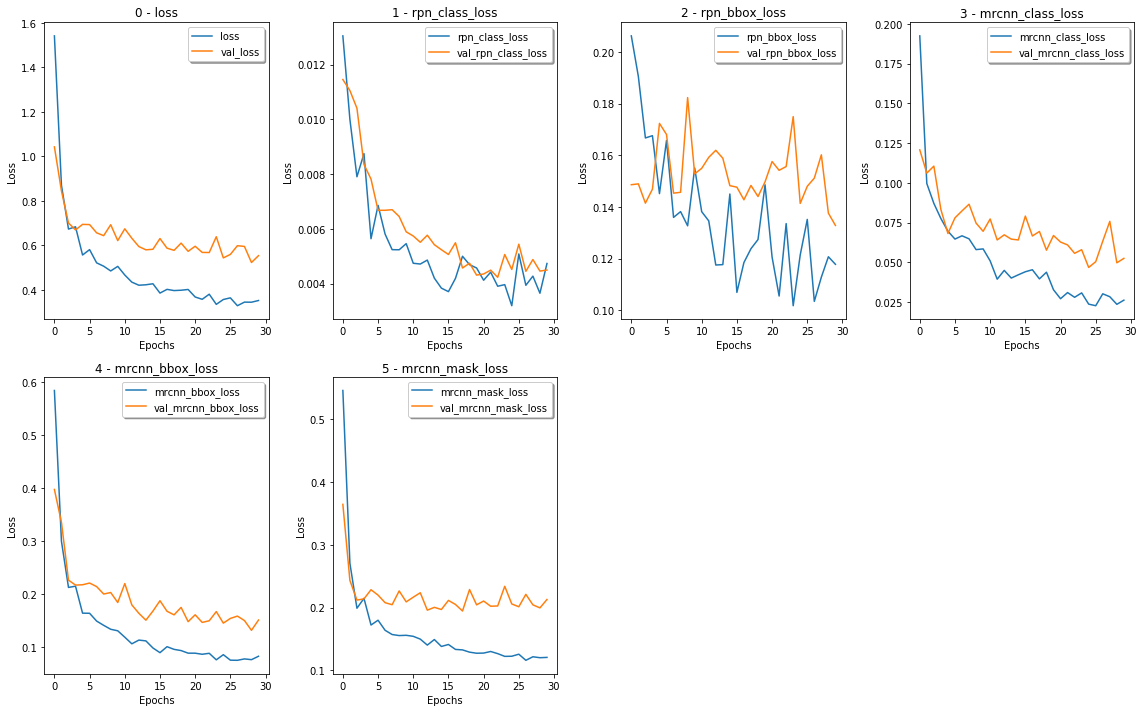

In [14]:
# Plot training stats for each of the networks.
plot_history(history)

# Inference

In [15]:
# Find last trained weights
weights_path = model.find_last()
weights_path

'/home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/sign20190328T1612/mask_rcnn_sign_0030.h5'

In [16]:
class InferenceConfig(det.DetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inf_config = InferenceConfig('sign', ['sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign'])

inf_model = modellib.MaskRCNN(mode="inference", 
                              config=inf_config,
                              model_dir=models_dir)

inf_config.display()

# enabled for testing
#weights_path = os.path.join(models_dir, "sign20180508T1523_mask_rcnn_sign_0075.h5")

print("Using weights: ", weights_path)

inf_model.load_weights(weights_path, by_name=True)


W0328 16:45:21.673773 140686078592832 deprecation.py:323] From /home/saad/notebook/csci_e89/project/saad_mrcnn/mrcnn/model.py:776: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.



Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM             

In [17]:
import glob

def detect_instance(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """

    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    for f in det_filenames:
        print("Processing image {}".format(f))

        test_img = plt.imread(f)
        print(test_img.shape)

        plt.imshow(test_img)
        # visualize.display_images([test_img])

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'])

        print(results['class_ids'])

In [18]:
import time

def detect_instances(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """
        
    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    fig = plt.figure(figsize=(16,10))

    n_cols = 3
    n_rows = math.ceil(len(det_filenames) / n_cols) 
    
    
    for i, f in enumerate(det_filenames):
        
        print("Processing image {}".format(f))
        
        ax = plt.subplot( n_rows, n_cols, i+1)

        test_img = plt.imread(f)

        start_time = time.time()
        
        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]
        
        elapsed_time = time.time() - start_time

        print("Elapsed time: {:.4f}, Objects detected: {}".format( elapsed_time, len(results['class_ids'])))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'],
                                    ax=ax)

        print(results['class_ids'])
        



Processing image /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs/test/2-sm-dupontcircle-8791.jpg
Processing 1 images
image                    shape: (400, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Elapsed time: 2.7449, Objects detected: 1
[4]
Processing image /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs/test/IMG_4716.jpg
Processing 1 images
image                    shape: (481, 360, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchor

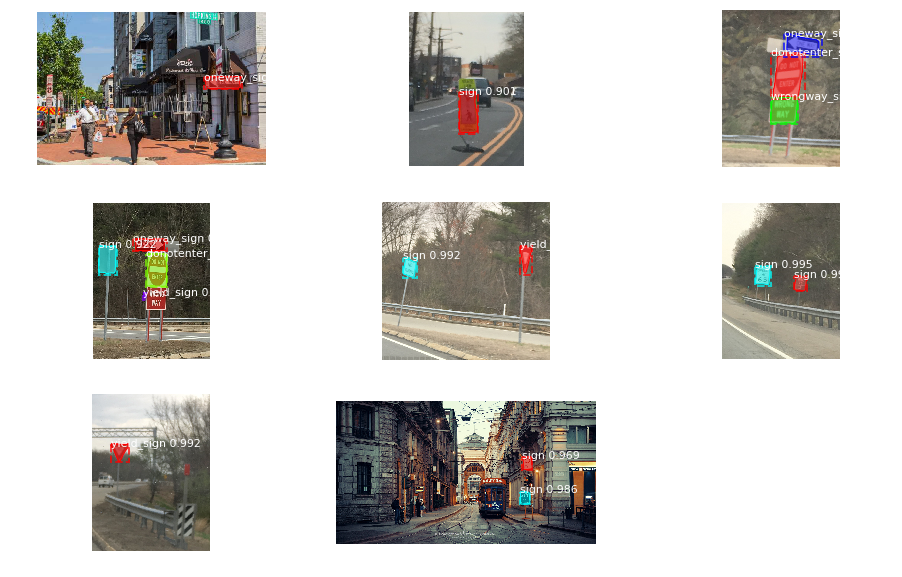

In [19]:
image_test_dir = os.path.join(dataset_path, "test/")

if debugging:
    r = detect_instance(inf_config.ALL_CLASS_NAMES, image_test_dir)
else:
    r = detect_instances(inf_config.ALL_CLASS_NAMES, image_test_dir)